# Assignment1: Visualization and Imputation

In [1]:
# Import library

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data

data_dir = "./aavail-target.csv"

data_df = pd.read_csv(data_dir)

print(data_df.shape)
data_df.head()

(1000, 7)


,customer_id,country_name,age,customer_name,is_subscriber,subscriber_type,num_streams
0,1,united_states,21.0,Kasen Todd,True,aavail_premium,23.0
1,2,singapore,31.0,Ensley Garza,False,NaN,12.0
2,3,united_states,22.0,Lillian Carey,False,aavail_premium,22.0
3,4,united_states,21.0,Beau Christensen,True,aavail_basic,19.0
4,5,singapore,22.0,Ernesto Gibson,True,aavail_premium,23.0


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1000 non-null   int64  
 1   country_name     1000 non-null   object 
 2   age              1000 non-null   float64
 3   customer_name    1000 non-null   object 
 4   is_subscriber    1000 non-null   bool   
 5   subscriber_type  928 non-null    object 
 6   num_streams      954 non-null    float64
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 48.0+ KB


In [4]:
# Study the data - Null data
print("Null data in csv file\n")
print(data_df.isnull().sum())

Null data in csv file

customer_id         0
country_name        0
age                 0
customer_name       0
is_subscriber       0
subscriber_type    72
num_streams        46
dtype: int64


In [ ]:
# Back up data
data_df_bk = data_df.copy()

#Fill Null data for plot
data_df["subscriber_type"] = data_df["subscriber_type"].fillna("Null")
data_df["num_streams"] = data_df["num_streams"].fillna(-100)

In [ ]:
# Encode the categorical columns for plot with One Hot Encoder
from sklearn import preprocessing

categorical_columns = ["country_name", "is_subscriber", "subscriber_type"]

for categorical_column in categorical_columns:

    
    ## One Hot Encoder
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(data_df[[categorical_column]]).toarray())
    ## Rename column name
    columns = [s.replace("x0", categorical_column) for s in enc.get_feature_names()]
    enc_df.columns = columns

    # merge with main df bridge_df on key values
    data_df = data_df.join(enc_df)

#Add one hot column for null num_streams
data_df["num_streams_Null"] = 0
data_df["num_streams_Null"][data_df["num_streams"] == -100] = 1
    
print(data_df.shape)
data_df.head()

### Study the distribution of Lost data

* subscriber_type

In [ ]:

plt.figure(figsize = (8, 6))
sns.countplot(x = "country_name", hue = "subscriber_type", data = data_df)
plt.title("Country name - Subscribe type")

subscriber_type_null_rate_us = data_df[(data_df["country_name"] == "united_states")&(data_df["subscriber_type_Null"] == 1)].shape[0] / data_df[data_df["country_name"] == "united_states"].shape[0]
subscriber_type_null_rate_sp = data_df[(data_df["country_name"] == "singapore")&(data_df["subscriber_type_Null"] == 1)].shape[0] / data_df[data_df["country_name"] == "singapore"].shape[0]

print("US data mount = ", data_df[data_df["country_name"] == "united_states"].shape[0])
print("Singapore data mount = ", data_df[data_df["country_name"] == "singapore"].shape[0])
print("Null rate of Subscribe type in US is : ", subscriber_type_null_rate_us)
print("Null rate of Subscribe type in Singapore is : ", subscriber_type_null_rate_sp)

* Num Streams

In [ ]:
plt.figure(figsize = (8, 6))
sns.countplot(x = "country_name", hue = "num_streams_Null", data = data_df)
plt.title("Country name - Subscribe type")
num_streams_null_rate_us = data_df[(data_df["country_name"] == "united_states")&(data_df["num_streams_Null"] == 1)].shape[0] / data_df[data_df["country_name"] == "united_states"].shape[0]
num_streams_null_rate_sp = data_df[(data_df["country_name"] == "singapore")&(data_df["num_streams_Null"] == 1)].shape[0] / data_df[data_df["country_name"] == "singapore"].shape[0]
print("Null rate of num streams in US is : ", num_streams_null_rate_us)
print("Null rate of num streams in Singapore is : ", num_streams_null_rate_sp)

In [ ]:
# Study the data distribution
plt.figure(figsize = (8, 6))
sns.distplot(data_df["age"][data_df["num_streams"] != -100], kde = False, label = "w./o. Lost Num_streams")
sns.distplot(data_df["age"][data_df["num_streams"] == -100], kde = False, label = "w. Lost Num_streams")
plt.title(" Age - num streams")
plt.legend()

### Q1: Investigate the extent and nature of the missing data 

### Answer 1: 
#### There are 7 columns ('customer_id', 'country_name', 'age', 'customer_name', 'is_subscriber', 'subscriber_type', 'num_streams') with 1000 records in the dataset, and missing data exists at the columns of 'subscriber_type' and 'num_streams'.
* **subscriber_type**: Totally 7.2% of data was lost. since the US data (700 records) and Singapore (300 records) are unbalanced (70%-30%), the null rate for these two country are almost the same (US: 7.28%, Singapore: 7%), therefore the missing data on 'subscriber_type' are **MCAR** with not affect bias.
* **num_streams**: Totally 4.6% of data was lost. However, the null rate on US (3.4%) and Singapore (7.3%) are significant different. Moreover, the lost data are concentrated in the range of user under 30 ages, therefore the missing data on 'subscriber_type' are **MAR**.

---

### Q2: Design and implement an imputation technique for the missing data

### Answer 2:
* subscriber_type: For MCAR type data, it is a good choice to apply the **SimpleImputer** method and fill the random missing value with most_frequent data. 
* num_streams: For MAR type data, it is possible to fill the lost data with the Nearest Neighbors using **KNNImputer**.

In [13]:
#Remove the filled Null data
columns = ['customer_id', 'country_name', 'age', 'customer_name',
       'is_subscriber', 'subscriber_type', 'num_streams']

data_df["subscriber_type"] = data_df_bk["subscriber_type"]
data_df["num_streams"] = data_df_bk["num_streams"]
print(data_df[columns].isnull().sum())

customer_id         0
country_name        0
age                 0
customer_name       0
is_subscriber       0
subscriber_type    72
num_streams        46
dtype: int64


* subscriber_type

In [14]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_df["subscriber_type"] = imp.fit_transform(data_df[["subscriber_type"]])
print(data_df["subscriber_type"].unique())
print(data_df[columns].isnull().sum())

['aavail_premium' 'aavail_basic' 'aavail_unlimited']
customer_id         0
country_name        0
age                 0
customer_name       0
is_subscriber       0
subscriber_type     0
num_streams        46
dtype: int64


* num_streams

In [15]:
data_df.columns.values

array(['customer_id', 'country_name', 'age', 'customer_name',
       'is_subscriber', 'subscriber_type', 'num_streams',
       'country_name_singapore', 'country_name_united_states',
       'is_subscriber_False', 'is_subscriber_True',
       'subscriber_type_Null', 'subscriber_type_aavail_basic',
       'subscriber_type_aavail_premium',
       'subscriber_type_aavail_unlimited', 'num_streams_Null'],
      dtype=object)

In [21]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
columns_fitting = ['age', 'country_name_singapore', 'country_name_united_states',
       'is_subscriber_False', 'is_subscriber_True', 'num_streams']
array_imputed = imputer.fit_transform(data_df[columns_fitting])
data_df['num_streams'] = array_imputed[:, -1]
print(data_df[columns].isnull().sum())

customer_id        0
country_name       0
age                0
customer_name      0
is_subscriber      0
subscriber_type    0
num_streams        0
dtype: int64


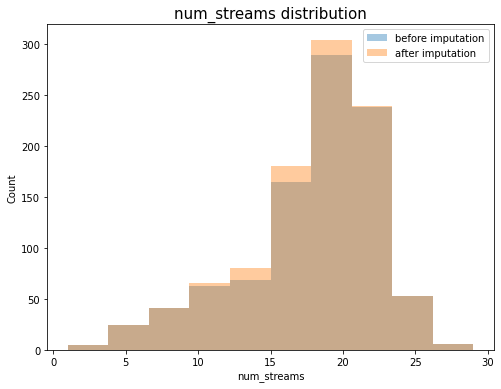

In [28]:
### Plot the num stream distribution before / after imputation for comparison
plt.figure(figsize = (8,6))

sns.distplot(data_df_bk['num_streams'], bins = 10,kde = False ,label = 'before imputation')
sns.distplot(data_df['num_streams'], bins = 10, kde = False ,label = 'after imputation')
plt.ylabel("Count")
plt.title("num_streams distribution", fontsize = 15)
plt.legend()

#### The distribution of num_streams after imputation is consist with the raw data

---

### Q3: Produce a visualization for AAVAIL stakeholders on the US and Singapore markets using your modified dataset
### Answer 3: See Below

* US Market study

In [30]:
#Split the dataframe
data_df_us = data_df[data_df["country_name"] == "united_states"]
print(data_df_us.shape)
print(data_df_us["country_name"].unique())

(700, 16)
['united_states']


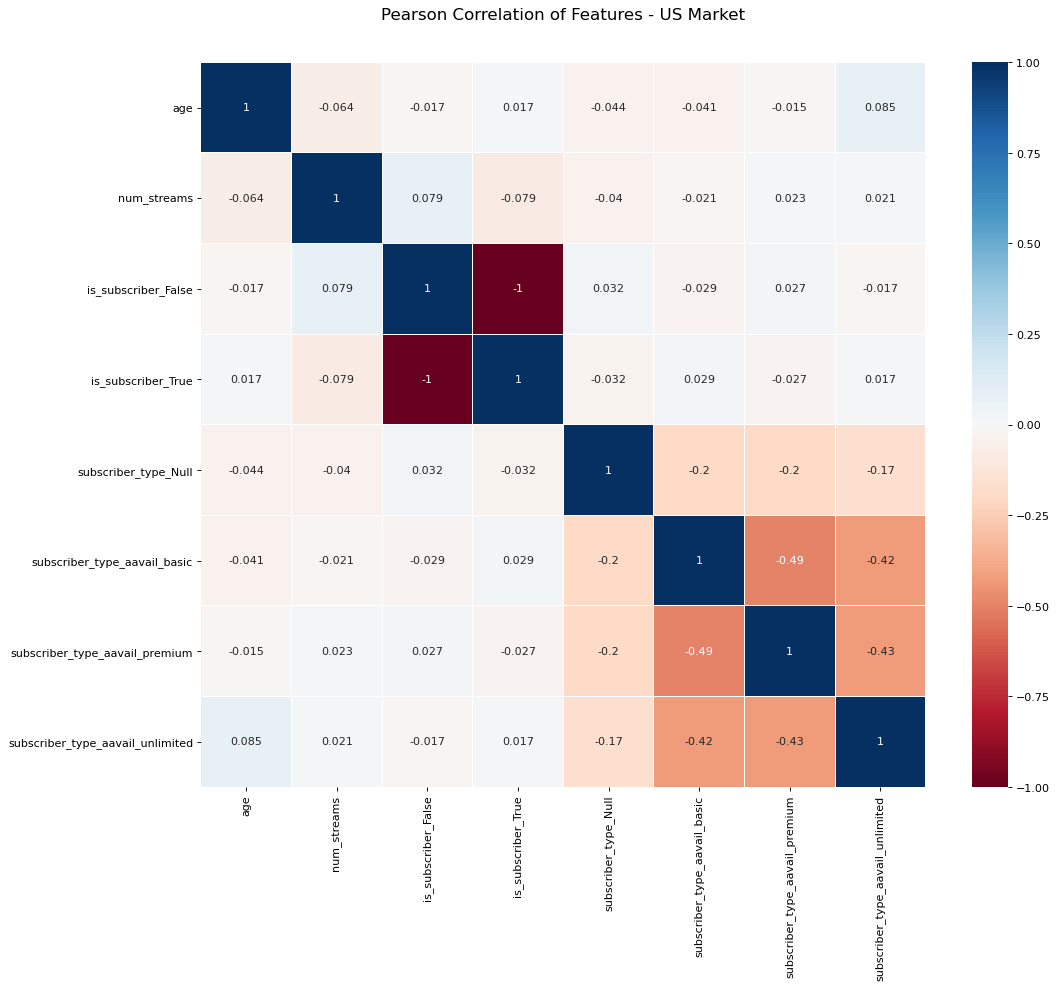

In [37]:
### Study the correlation

columns = ['age', 'num_streams',
       'is_subscriber_False', 'is_subscriber_True',
       'subscriber_type_Null', 'subscriber_type_aavail_basic',
       'subscriber_type_aavail_premium',
       'subscriber_type_aavail_unlimited',]

colormap = plt.cm.RdBu
plt.figure(figsize=(15,12), dpi=80)
title = 'Pearson Correlation of Features - US Market'
plt.title(title, y=1.05, size=15)
sns.heatmap(data_df_us[columns].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [61]:
data_df_us[columns].describe()

,age,num_streams,is_subscriber_False,is_subscriber_True,subscriber_type_Null,subscriber_type_aavail_basic,subscriber_type_aavail_premium,subscriber_type_aavail_unlimited
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,27.711429,18.838286,0.154286,0.845714,0.072857,0.328571,0.331429,0.267143
std,9.114414,4.136874,0.361481,0.361481,0.260088,0.470030,0.471063,0.442784
min,14.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,34.000000,22.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,57.000000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'age vs num_streams - US Market')

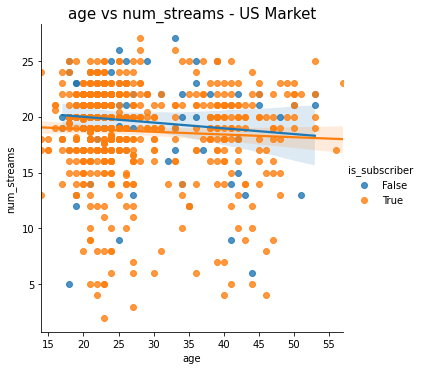

In [89]:
sns.lmplot(x = 'age', y = 'num_streams', hue = 'is_subscriber', data = data_df_us)
plt.title("age vs num_streams - US Market", fontsize = 15)

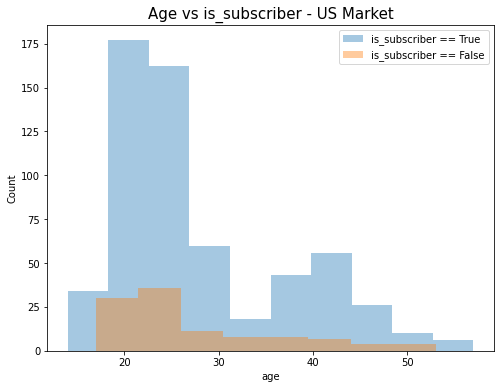

In [87]:
plt.figure(figsize = (8, 6))
sns.distplot(data_df_us["age"][data_df_us['is_subscriber'] == True], kde = False, bins = 10,label = "is_subscriber == True")
sns.distplot(data_df_us["age"][data_df_us['is_subscriber'] == False], kde = False, bins = 8, label = "is_subscriber == False")
plt.ylabel("Count")
plt.title("Age vs is_subscriber - US Market", fontsize = 15)
plt.legend()

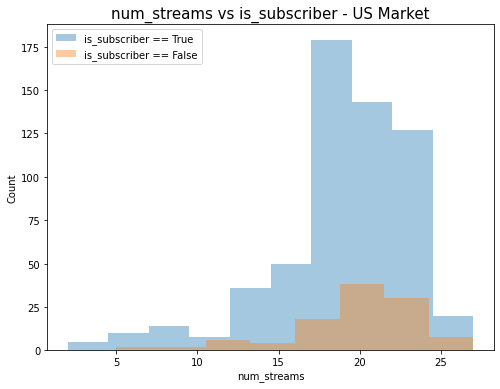

In [88]:
plt.figure(figsize = (8, 6))
sns.distplot(data_df_us["num_streams"][data_df_us['is_subscriber'] == True], kde = False, bins = 10,label = "is_subscriber == True")
sns.distplot(data_df_us["num_streams"][data_df_us['is_subscriber'] == False], kde = False, bins = 8, label = "is_subscriber == False")
plt.ylabel("Count")
plt.title("num_streams vs is_subscriber - US Market", fontsize = 15)
plt.legend()

### US Market Summary
* About 85% of customer with subscription
* Most customer are young people (under 30)
* Young people has more num_streams than old people
* Generally the old customer are more easy to become a subscriber (with higher subsription rate)
* num_streams is negative related with the Subscription
* Most people choose the "aavail_premium" subsription type

* Singapore

In [62]:
#Split the dataframe
data_df_sig = data_df[data_df["country_name"] == "singapore"]
print(data_df_sig.shape)
print(data_df_sig["country_name"].unique())

(300, 16)
['singapore']


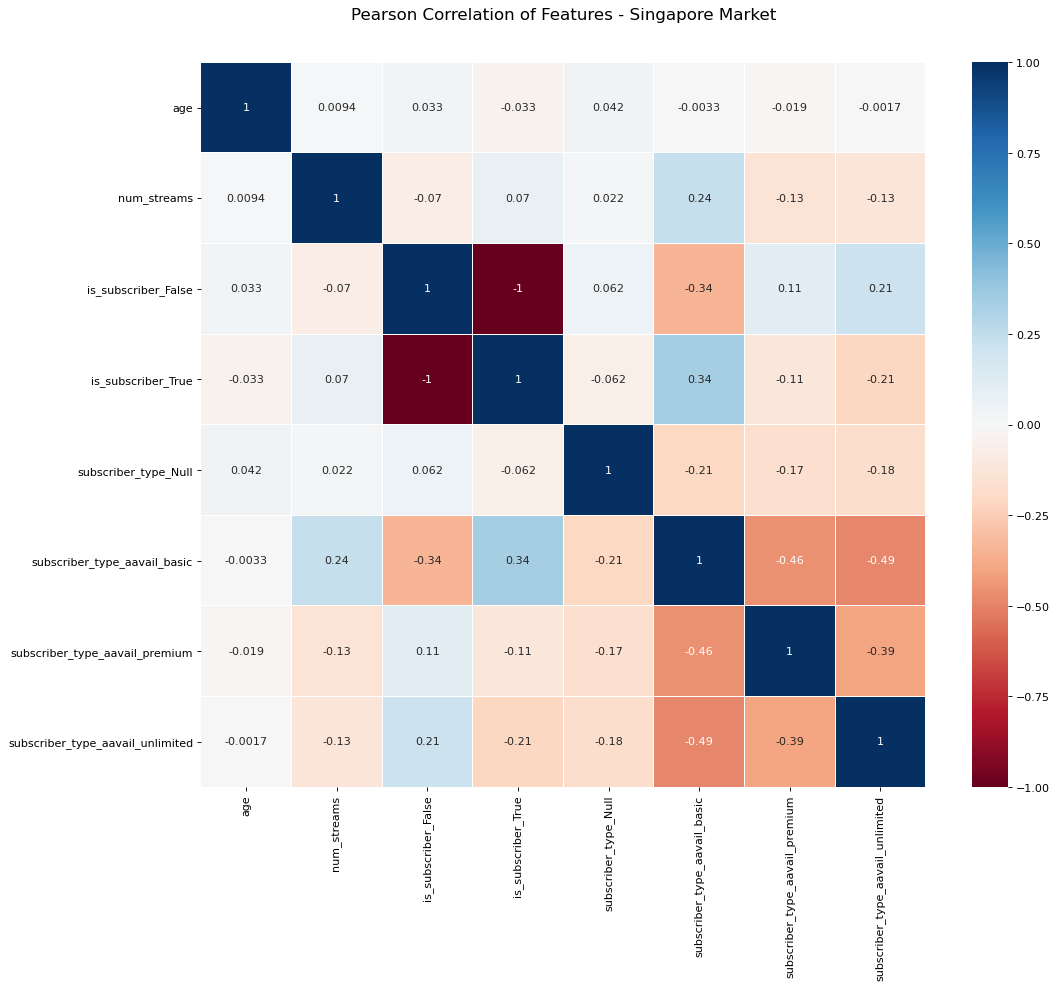

In [64]:
### Study the correlation

columns = ['age', 'num_streams',
       'is_subscriber_False', 'is_subscriber_True',
       'subscriber_type_Null', 'subscriber_type_aavail_basic',
       'subscriber_type_aavail_premium',
       'subscriber_type_aavail_unlimited',]

colormap = plt.cm.RdBu
plt.figure(figsize=(15,12), dpi=80)
title = 'Pearson Correlation of Features - Singapore Market'
plt.title(title, y=1.05, size=15)
sns.heatmap(data_df_sig[columns].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [66]:
data_df_sig[columns].describe()

,age,num_streams,is_subscriber_False,is_subscriber_True,subscriber_type_Null,subscriber_type_aavail_basic,subscriber_type_aavail_premium,subscriber_type_aavail_unlimited
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,27.113333,15.127333,0.603333,0.396667,0.070000,0.363333,0.270000,0.296667
std,9.134840,4.855937,0.490023,0.490023,0.255573,0.481763,0.444701,0.457552
min,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,18.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,55.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'age vs num_streams - Singapore Market')

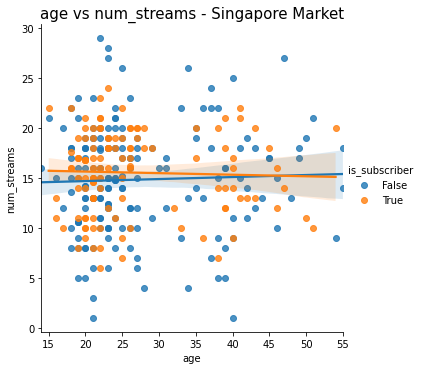

In [84]:
sns.lmplot(x = 'age', y = 'num_streams', hue = 'is_subscriber', data = data_df_sig)
plt.title("age vs num_streams - Singapore Market", fontsize = 15)

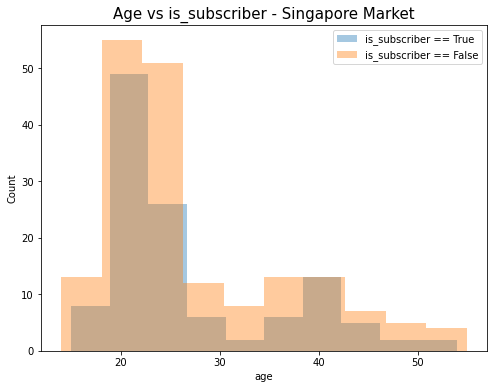

In [85]:
plt.figure(figsize = (8, 6))
sns.distplot(data_df_sig["age"][data_df_sig['is_subscriber'] == True], kde = False, bins = 10,label = "is_subscriber == True")
sns.distplot(data_df_sig["age"][data_df_sig['is_subscriber'] == False], kde = False, bins = 10, label = "is_subscriber == False")
plt.ylabel("Count")
plt.title("Age vs is_subscriber - Singapore Market", fontsize = 15)
plt.legend()

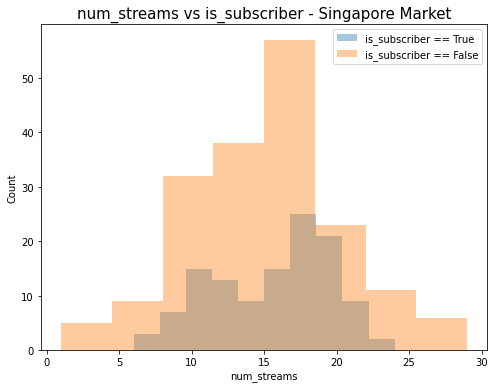

In [86]:
plt.figure(figsize = (8, 6))
sns.distplot(data_df_sig["num_streams"][data_df_sig['is_subscriber'] == True], kde = False, bins = 10,label = "is_subscriber == True")
sns.distplot(data_df_sig["num_streams"][data_df_sig['is_subscriber'] == False], kde = False, bins = 8, label = "is_subscriber == False")
plt.ylabel("Count")
plt.title("num_streams vs is_subscriber - Singapore Market", fontsize = 15)
plt.legend()

### Singapore Market Summary
* Only 40% of customer with subscription
* Most customer are young people (under 30)
* No clear relation between num_streams and customer age
* No clear relation between subscription rate and customer age
* num_streams is positive related with the Subscription
* Most people choose the "aavail_basic" subsription type
* The data amount is not enough while compared with US data, and more data are prefered for future study